In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Đọc dữ liệu từ file Excel
df1 = pd.read_excel("HomeData.xlsx")

def convert_price(price_str):
    if not isinstance(price_str, str):
        return np.nan
    try:
        if 'tỷ' in price_str:
            return float(price_str.replace(' tỷ', '').replace(',', '.')) * 1e9
        elif 'triệu' in price_str:
            return float(price_str.replace(' triệu', '').replace(',', '.')) * 1e6
        elif 'nghìn' in price_str:
            return float(price_str.replace(' nghìn', '').replace(',', '.')) * 1e3
        else:
            return float(price_str.replace(',', '.'))
    except ValueError:
        print(f"ValueError: Could not convert {price_str} to float.")
        return np.nan

def clean_area(area_str):
    if not isinstance(area_str, str):
        return np.nan
    area_str = area_str.replace(' m²', '')
    if ',' in area_str and '.' in area_str:
        if area_str.count('.') > area_str.count(','):
            area_str = area_str.replace('.', '')
            area_str = area_str.replace(',', '.')
        else:
            area_str = area_str.replace('.', '')
            area_str = area_str.replace(',', '.')
    elif ',' in area_str:
        area_str = area_str.replace(',', '.')
    elif '.' in area_str:
        area_str = area_str.replace('.', '')
    try:
        return float(area_str)
    except ValueError:
        print(f"ValueError: Could not convert {area_str} to float.")
        return np.nan
    
def update_bedroom_toilet(row):
    if row['area'] <= 50:
        if row['bedroom'] == 0:
            row['bedroom'] = 1
        if row['toilet'] == 0:
            row['toilet'] = 1
    elif 50 < row['area'] <= 150:
        if row['bedroom'] == 0:
            row['bedroom'] = 2
        if row['toilet'] == 0:
            row['toilet'] = 2
    elif 150 < row['area'] <= 300:
        if row['bedroom'] == 0:
            row['bedroom'] = 3
        if row['toilet'] == 0:
            row['toilet'] = 3
    elif 300 < row['area'] <= 500:
        if row['bedroom'] == 0:
            row['bedroom'] = 4
        if row['toilet'] == 0:
            row['toilet'] = 4
    elif 500 < row['area'] <= 800:
        if row['bedroom'] == 0:
            row['bedroom'] = 5
        if row['toilet'] == 0:
            row['toilet'] = 5
    elif 800 < row['area'] <= 1000:
        if row['bedroom'] == 0:
            row['bedroom'] = 6
        if row['toilet'] == 0:
            row['toilet'] = 6
    return row

# Xử lý cột 'location' nếu có
if 'location' in df1.columns:
    df1[['district', 'province']] = df1['location'].str.split(', ', expand=True)
    df1.drop(columns=['location'], inplace=True)

# Xóa cột 'price_per_m2'
df1.drop(columns=['price_per_m2'], inplace=True)

# Xóa các hàng có giá là "Giá thỏa thuận"
df1 = df1[df1['price'] != "Giá thỏa thuận"]

# Thay thế giá trị NaN trong cột 'bedroom' và 'toilet' bằng 0
df1['bedroom'] = df1['bedroom'].fillna(0)
df1['toilet'] = df1['toilet'].fillna(0)

# Áp dụng các hàm chuyển đổi
df1['price'] = df1['price'].astype(str).apply(convert_price)
df1['area'] = df1['area'].apply(clean_area)

# Chuyển đổi 'area' sang kiểu số
df1['area'] = pd.to_numeric(df1['area'], errors='coerce')

# Áp dụng hàm cập nhật số phòng ngủ và toilet
df1 = df1.apply(update_bedroom_toilet, axis=1)

# Lọc các hàng có giá trị 'bedroom' và 'toilet' khác 0
df1 = df1[(df1['bedroom'] != 0) | (df1['toilet'] != 0)]

# Xóa các hàng có giá trị thiếu
df1 = df1.dropna()

# Hoặc thay thế giá trị thiếu bằng giá trị trung bình
df1['area'] = df1['area'].fillna(df1['area'].mean())
df1['price'] = df1['price'].fillna(df1['price'].median())

# Tính toán IQR
Q1 = df1[['price', 'area']].quantile(0.25)
Q3 = df1[['price', 'area']].quantile(0.75)
IQR = Q3 - Q1

# Xác định outliers
outliers = (df1[['price', 'area']] < (Q1 - 1.5 * IQR)) | (df1[['price', 'area']] > (Q3 + 1.5 * IQR))
print(outliers.sum())

# Loại bỏ các outliers
df1 = df1[~outliers.any(axis=1)]

# Loại bỏ giá nhà quá cao hoặc quá thấp
df1 = df1[(df1['price'] > 1e5) & (df1['price'] < 1e13)]
df1 = df1[(df1['area'] > 10) & (df1['area'] < 1000)]

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import joblib

# Mã hóa các đặc trưng phân loại (district, province)
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df1[['district', 'province']])

# Kết hợp các đặc trưng mã hóa với các đặc trưng số học
X = np.hstack((encoded_features.toarray(), df1[['area', 'bedroom', 'toilet']].values))
y = df1['price']

# Chia tập dữ liệu thành training và testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán giá nhà mới
new_house = pd.DataFrame({
    'district': ['Quận 2'],
    'province': ['Hồ Chí Minh'],
    'area': [116.87],
    'bedroom': [1],
    'toilet': [2]
})

# Mã hóa dữ liệu nhà mới
encoded_new_house = encoder.transform(new_house[['district', 'province']]).toarray()
new_house_features = np.hstack((encoded_new_house, new_house[['area', 'bedroom', 'toilet']].values))

# Dự đoán giá
predicted_price = model.predict(new_house_features)
print(f"Giá nhà dự đoán: {predicted_price[0]:,.0f} VND")

# Lưu mô hình và encoder
joblib.dump(model, 'model.pkl')
joblib.dump(encoder, 'encoder.pkl')


price    4704
area     4576
dtype: int64
Giá nhà dự đoán: 12,367,154,176 VND


['encoder.pkl']

In [ ]:
# Load the data
df1 = pd.read_excel("HomeData.xlsx")
df1.head()

,price,area,price_per_m2,bedroom,toilet,location
0,"2,56 tỷ",59 m²,"43,39 tr/m²",2.00,2.00,"Quận 9, Hồ Chí Minh"
1,"7,5 tỷ",92 m²,"81,52 tr/m²",2.00,2.00,"Quận 2, Hồ Chí Minh"
2,Giá thỏa thuận,90 m²,NaN,NaN,NaN,"Đông Anh, Hà Nội"
3,"3,5 tỷ",115 m²,"30,44 tr/m²",3.00,2.00,"Thạch Thất, Hà Nội"
4,"3,3 tỷ","87,5 m²","37,71 tr/m²",2.00,2.00,"Vân Đồn, Quảng Ninh"


In [ ]:
def convert_price(price_str):
    if not isinstance(price_str, str):
        # Handle cases where the value is not a string (e.g., NaN or numeric values)
        return np.nan
    try:
        if 'tỷ' in price_str:
            return float(price_str.replace(' tỷ', '').replace(',', '.')) * 1e9
        elif 'triệu' in price_str:
            return float(price_str.replace(' triệu', '').replace(',', '.')) * 1e6
        elif 'nghìn' in price_str:
            return float(price_str.replace(' nghìn', '').replace(',', '.')) * 1e3
        else:
            # Handle cases where the value is already numeric
            return float(price_str.replace(',', '.'))
    except ValueError:
        print(f"ValueError: Could not convert {price_str} to float.")
        return np.nan

In [ ]:
def clean_area(area_str):
    if not isinstance(area_str, str):
        return np.nan

    # Remove ' m²' suffix
    area_str = area_str.replace(' m²', '')

    # Handle cases with periods and commas
    if ',' in area_str and '.' in area_str:
        # Determine if periods or commas are used as decimal separators
        if area_str.count('.') > area_str.count(','):
            # Assume periods are thousand separators
            area_str = area_str.replace('.', '')  # Remove all periods
            area_str = area_str.replace(',', '.')  # Replace the remaining comma with a period
        else:
            # Assume comma is the decimal point
            area_str = area_str.replace('.', '')  # Remove periods
            area_str = area_str.replace(',', '.')  # Replace comma with a period
    elif ',' in area_str:
        # Only comma, assume it is a decimal point
        area_str = area_str.replace(',', '.')
    elif '.' in area_str:
        # Only period, assume it is a thousand separator
        area_str = area_str.replace('.', '')  # Remove periods

    try:
        return float(area_str)
    except ValueError:
        print(f"ValueError: Could not convert {area_str} to float.")
        return np.nan

In [ ]:
def update_bedroom_toilet(row):
    # Trường hợp area <= 50
    if row['area'] <= 50:
        if row['bedroom'] == 0:
            row['bedroom'] = 1
        if row['toilet'] == 0:
            row['toilet'] = 1
    
    # Trường hợp 50 < area <= 150
    elif 50 < row['area'] <= 150:
        if row['bedroom'] == 0:
            row['bedroom'] = 2
        if row['toilet'] == 0:
            row['toilet'] = 2
    
    # Trường hợp 150 < area <= 300
    elif 150 < row['area'] <= 300:
        if row['bedroom'] == 0:
            row['bedroom'] = 3
        if row['toilet'] == 0:
            row['toilet'] = 3
    
    # Trường hợp 300 < area <= 500
    elif 300 < row['area'] <= 500:
        if row['bedroom'] == 0:
            row['bedroom'] = 4
        if row['toilet'] == 0:
            row['toilet'] = 4
    
    # Trường hợp 500 < area <= 800
    elif 500 < row['area'] <= 800:
        if row['bedroom'] == 0:
            row['bedroom'] = 5
        if row['toilet'] == 0:
            row['toilet'] = 5
    
    # Trường hợp 800 < area <= 1000
    elif 800 < row['area'] <= 1000:
        if row['bedroom'] == 0:
            row['bedroom'] = 6
        if row['toilet'] == 0:
            row['toilet'] = 6
    
    return row


In [ ]:
# Handle 'location' column if it exists
if 'location' in df1.columns:
    df1[['district', 'province']] = df1['location'].str.split(', ', expand=True)
    df1.drop(columns=['location'], inplace=True)

# Drop column price_per_m2
df1.drop(columns=['price_per_m2'], inplace=True)

# Drop rows where price is "Giá thỏa thuận"
df1 = df1[df1['price'] != "Giá thỏa thuận"]

# Replace NaN values in 'bedroom' and 'toilet' columns with 0
df1['bedroom'] = df1['bedroom'].fillna(0)
df1['toilet'] = df1['toilet'].fillna(0)

# Apply conversion functions
df1['price'] = df1['price'].astype(str).apply(convert_price)

# Apply the cleaning function
df1['area'] = df1['area'].apply(clean_area)

# Convert 'area' to numeric type
df1['area'] = pd.to_numeric(df1['area'], errors='coerce')

# Apply the function to update bedroom and toilet
df1 = df1.apply(update_bedroom_toilet, axis=1)

# Filter out rows where both 'bedroom' and 'toilet' are 0
df1 = df1[(df1['bedroom'] != 0) | (df1['toilet'] != 0)]

# Display the updated DataFrame
df1.head()
df1.shape

NameError: name 'df1' is not defined

In [ ]:
# Kiểm tra giá trị thiếu
print(df1.isnull().sum())

price       0
area        0
bedroom     0
toilet      0
district    0
province    0
dtype: int64


In [ ]:
# Loại bỏ các hàng có giá trị thiếu
df1 = df1.dropna()

# Hoặc thay thế giá trị thiếu bằng giá trị trung bình
df1['area'] = df1['area'].fillna(df1['area'].mean())
df1['price'] = df1['price'].fillna(df1['price'].median())


In [ ]:
# Tính toán IQR
Q1 = df1[['price', 'area']].quantile(0.25)
Q3 = df1[['price', 'area']].quantile(0.75)
IQR = Q3 - Q1

# Xác định outliers
outliers = (df1[['price', 'area']] < (Q1 - 1.5 * IQR)) | (df1[['price', 'area']] > (Q3 + 1.5 * IQR))
print(outliers.sum())

# Loại bỏ các outliers
df1 = df1[~outliers.any(axis=1)]


price    4704
area     4576
dtype: int64


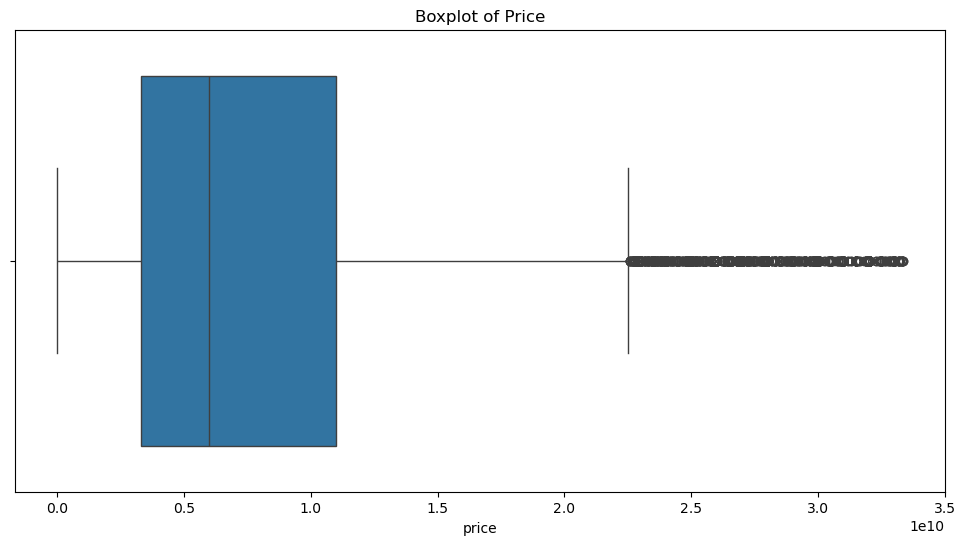

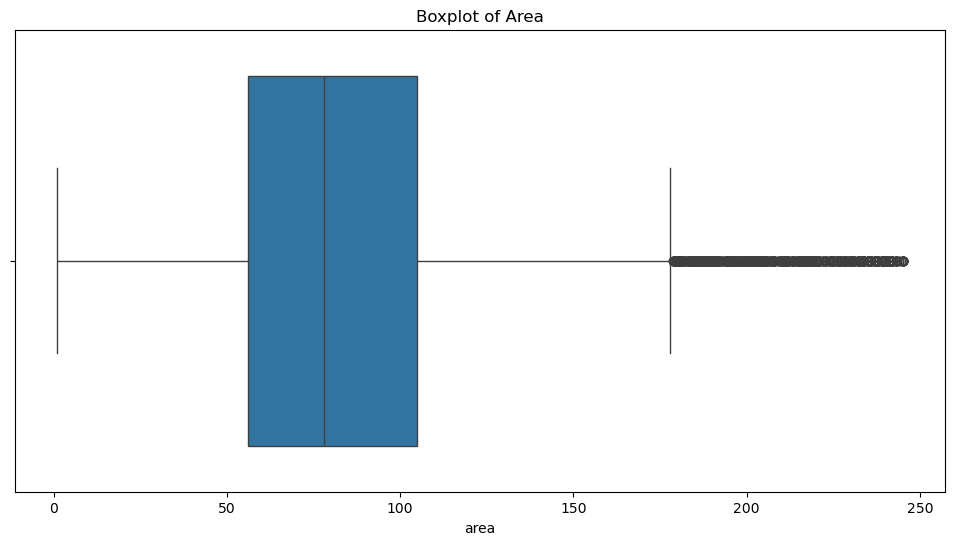

In [ ]:
import seaborn as sns

# Vẽ biểu đồ phân phối giá
plt.figure(figsize=(12, 6))
sns.boxplot(x=df1['price'])
plt.title('Boxplot of Price')
plt.show()

# Vẽ biểu đồ phân phối diện tích
plt.figure(figsize=(12, 6))
sns.boxplot(x=df1['area'])
plt.title('Boxplot of Area')
plt.show()


In [ ]:
# Ví dụ: Loại bỏ giá nhà quá cao hoặc quá thấp
df1 = df1[(df1['price'] > 1e5) & (df1['price'] < 1e13)]
df1 = df1[(df1['area'] > 10) & (df1['area'] < 1000)]


In [ ]:
print(df1.describe())
df1.shape

               price     area  bedroom   toilet
count       38436.00 38436.00 38436.00 38436.00
mean   8309715010.22    87.23     3.12     2.89
std    7011405055.57    42.92     2.46     2.42
min        103000.00    11.00     1.00     1.00
25%    3300000000.00    56.00     2.00     2.00
50%    6000000000.00    78.65     3.00     2.00
75%   11000000000.00   105.00     4.00     3.00
max   33340000000.00   245.00    46.00    50.00


(38436, 6)

In [ ]:
df1.to_csv('dataset.csv',encoding="utf-8-sig",index=False)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

df = pd.read_csv('dataset.csv')

# Encode các đặc trưng phân loại (district, province)
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['district', 'province']])

# Kết hợp các đặc trưng được mã hóa với các đặc trưng số học
X = np.hstack((encoded_features.toarray(), df[['area', 'bedroom', 'toilet']].values))
y = df['price']

# Chia tập dữ liệu thành training và testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình hồi quy tuyến tính
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán giá nhà mới
new_house = pd.DataFrame({
    'district': ['Quận 2'],
    'province': ['Hồ Chí Minh'],
    'area': [116.87],
    'bedroom': [1],
    'toilet': [2]
})

# Encode dữ liệu nhà mới
encoded_new_house = encoder.transform(new_house[['district', 'province']]).toarray()
new_house_features = np.hstack((encoded_new_house, new_house[['area', 'bedroom', 'toilet']].values))

# Dự đoán giá
predicted_price = model.predict(new_house_features)
print(f"Giá nhà dự đoán: {predicted_price[0]:,.0f} VND")


Giá nhà dự đoán: 17,961,820,160 VND
